Read the image, then calculate the number of pixels corresponding to different structures. Identify the image with the largest aneurysm, the image with the largest connected region, and the image with the largest total area.

Five criteria: 
maximum connecting area, 
maximum aneurysm, 
total area of maximum connecting area and aneurysm, 
minimum overlap, 
minimum ratio of overlap area to aneurysm area (i.e. relatively small overlap area, relatively large aneurysm)

In [ ]:
from PIL import Image
import os
import numpy as np

# Define folder path
folder_number = 'C0001'
folder_path = os.path.join(r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results", folder_number + "saved_images")


# Define color ranges (in RGB format)
red_color = np.array([255, 0, 0])
green_color = np.array([0, 128, 0])
blue_color = np.array([0, 0, 255])
pink_color = np.array([255, 192, 203])  # RGB value for pink color (overlap region)

# Define color tolerance
tolerance = 50

def count_pixels_by_color(image, target_color, tolerance):
    """Use NumPy to count the number of pixels of a specified color in an image"""
    image_array = np.array(image)  # Convert the image to a NumPy array
    color_diff = np.abs(image_array - target_color)  # Calculate color differences
    within_tolerance = np.all(color_diff <= tolerance, axis=-1)  # Check if within tolerance range
    return np.sum(within_tolerance)  # Return the number of pixels that match

# Initialize variables to store maximum values and corresponding filenames
max_connection_region_pixels = 0
max_connection_region_file = None

max_aneurysm_pixels = 0
max_aneurysm_file = None

max_connection_region_aneurysm_pixels = 0
max_connection_region_aneurysm_file = None

min_overlap_pixels = float('inf')  # Initialize with a very large value
min_overlap_file_pair = None

best_score = -1
best_score_file_pair = None
# Open file to save intermediate results
with open(os.path.join(folder_path, 'results.txt'), 'w') as result_file:
    # Iterate over all files in the folder
    no_overlap_files = [f for f in os.listdir(folder_path) if '2d_projection_no_overlap_' in f and f.endswith('.png')]
    overlap_files = [f for f in os.listdir(folder_path) if '2d_projection_overlap_' in f and f.endswith('.png')]
    
    # Create a dictionary to map angles to file names
    no_overlap_dict = {f.split('_')[-1].replace('.png', ''): f for f in no_overlap_files}
    overlap_dict = {f.split('_')[-1].replace('.png', ''): f for f in overlap_files}

    # Iterate over the no_overlap images and find corresponding overlap images
    for angle, no_overlap_filename in no_overlap_dict.items():
        if angle in overlap_dict:
            overlap_filename = overlap_dict[angle]
            
            # Load the no_overlap and overlap images
            no_overlap_image = Image.open(os.path.join(folder_path, no_overlap_filename)).convert('RGB')
            overlap_image = Image.open(os.path.join(folder_path, overlap_filename)).convert('RGB')
            
            # Count pixel areas for each image
            blood_vessel_pixels = count_pixels_by_color(no_overlap_image, red_color, tolerance)
            connection_region_pixels = count_pixels_by_color(no_overlap_image, green_color, tolerance)
            aneurysm_pixels = count_pixels_by_color(no_overlap_image, blue_color, tolerance)
            
            # Count pink overlap pixels
            pink_overlap_pixels = count_pixels_by_color(overlap_image, pink_color, tolerance)
            
            # Write results to the file
            result_file.write(f"File (no_overlap): {no_overlap_filename}\n")
            result_file.write(f"File (overlap): {overlap_filename}\n")
            result_file.write(f"blood_vessel_pixels: {blood_vessel_pixels}\n")
            result_file.write(f"connection_region_pixels: {connection_region_pixels}\n")
            result_file.write(f"aneurysm_pixels: {aneurysm_pixels}\n")
            result_file.write(f"pink_overlap_pixels: {pink_overlap_pixels}\n")
            result_file.write("-" * 30 + "\n")

            # Compare connection_region_pixels count
            if connection_region_pixels > max_connection_region_pixels:
                max_connection_region_pixels = connection_region_pixels
                max_connection_region_file = no_overlap_filename
            
            # Compare aneurysm_pixels count
            if aneurysm_pixels > max_aneurysm_pixels:
                max_aneurysm_pixels = aneurysm_pixels
                max_aneurysm_file = no_overlap_filename
            
            # Compare the sum of aneurysm_pixels and connection_region_pixels
            connection_region_aneurysm_pixels = connection_region_pixels + aneurysm_pixels
            if connection_region_aneurysm_pixels > max_connection_region_aneurysm_pixels:
                max_connection_region_aneurysm_pixels = connection_region_aneurysm_pixels
                max_connection_region_aneurysm_file = no_overlap_filename

            # Compare overlap pixels (pink area)
            if pink_overlap_pixels < min_overlap_pixels:
                min_overlap_pixels = pink_overlap_pixels
                min_overlap_file_pair = (no_overlap_filename, overlap_filename)

            # Calculate the score of the objective function
            if aneurysm_pixels + pink_overlap_pixels > 0:  # Avoid division by zero
                score = aneurysm_pixels / (aneurysm_pixels + pink_overlap_pixels)
            else:
                score = 0  # If both areas are 0, set score to 0

            # Compare and update best score
            if score > best_score:
                best_score = score
                best_score_file_pair = (no_overlap_filename, overlap_filename, score)

# Output final results
print("\nResults:")
print(f"Image with most connection_region pixels: {max_connection_region_file} (connection_region_pixels: {max_connection_region_pixels})")
print(f"Image with most aneurysm pixels: {max_aneurysm_file} (aneurysm_pixels: {max_aneurysm_pixels})")
print(f"Image with most connection_region and aneurysm pixels combined: {max_connection_region_aneurysm_file} (connection_region and aneurysm pixels: {max_connection_region_aneurysm_pixels})")
print(f"Image pair with smallest overlap pixels: {min_overlap_file_pair[1]})")

print(f"Maximize aneurysm area and minimize overlap area): {best_score_file_pair[1]} (Score: {best_score_file_pair[2]})")



Results:
Image with most connection_region pixels: 2d_projection_no_overlap_130.png (connection_region_pixels: 18022)
Image with most aneurysm pixels: 2d_projection_no_overlap_30.png (aneurysm_pixels: 156131)
Image with most connection_region and aneurysm pixels combined: 2d_projection_no_overlap_30.png (connection_region and aneurysm pixels: 167463)
Image pair with smallest overlap pixels: 28434)
Maximize aneurysm area and minimize overlap area): 2d_projection_overlap_360.png (Score: 0.8368075483826534)


Display the selected images

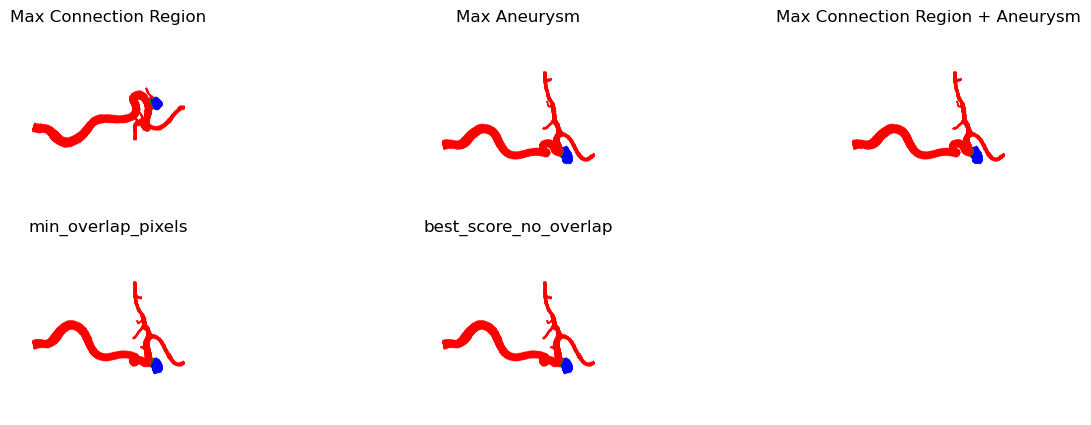

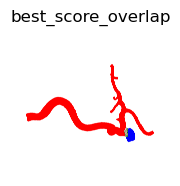

In [ ]:
import os
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

# Construct the full file paths using os.path.join
max_connection_region_path = os.path.join(folder_path, max_connection_region_file)
max_aneurysm_path = os.path.join(folder_path, max_aneurysm_file)
max_connection_region_aneurysm_path = os.path.join(folder_path, max_connection_region_aneurysm_file)
min_overlap_pixels_path = os.path.join(folder_path, min_overlap_file_pair[0])  # Use the filename, not the pixel count
best_score_overlap_path = os.path.join(folder_path, best_score_file_pair[1])
best_score_no_overlap_path = os.path.join(folder_path, best_score_file_pair[0])

# Use mpimg.imread to read the images
max_connection_region = mpimg.imread(max_connection_region_path)
max_aneurysm = mpimg.imread(max_aneurysm_path)
max_connection_region_aneurysm = mpimg.imread(max_connection_region_aneurysm_path)
min_overlap_pixels = mpimg.imread(min_overlap_pixels_path)
best_score_overlap = mpimg.imread(best_score_overlap_path)
best_score_no_overlap = mpimg.imread(best_score_no_overlap_path)


# Ensure the save directory exists
save_optimal_path = os.path.join(r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results", folder_number + "saved_images", "optimal")

if not os.path.exists(save_optimal_path):
    os.makedirs(save_optimal_path)

# Display the images using matplotlib and save them
plt.figure(figsize=(15, 5))

# Save max_connection_region
plt.imshow(max_connection_region)
plt.title("Max Connection Region")
plt.axis("off")
plt.savefig(os.path.join(save_optimal_path, os.path.basename(max_connection_region_path)), bbox_inches='tight', pad_inches=0, dpi=700)
plt.close()

# Save max_aneurysm
plt.imshow(max_aneurysm)
plt.title("Max Aneurysm")
plt.axis("off")
plt.savefig(os.path.join(save_optimal_path, os.path.basename(max_aneurysm_path)), bbox_inches='tight', pad_inches=0, dpi=700)
plt.close()

# Save max_connection_region_aneurysm
plt.imshow(max_connection_region_aneurysm)
plt.title("Max Connection Region + Aneurysm")
plt.axis("off")
plt.savefig(os.path.join(save_optimal_path, os.path.basename(max_connection_region_aneurysm_path)), bbox_inches='tight', pad_inches=0, dpi=700)
plt.close()

# Save min_overlap_pixels
plt.imshow(min_overlap_pixels)
plt.title("Min Overlap Pixels")
plt.axis("off")
plt.savefig(os.path.join(save_optimal_path, os.path.basename(min_overlap_pixels_path)), bbox_inches='tight', pad_inches=0, dpi=700)
plt.close()

# Save best_score_no_overlap
plt.imshow(best_score_no_overlap)
plt.title("Best Score No Overlap")
plt.axis("off")
plt.savefig(os.path.join(save_optimal_path, os.path.basename(best_score_no_overlap_path)), bbox_inches='tight', pad_inches=0, dpi=700)
plt.close()

# Save best_score_overlap
plt.imshow(best_score_overlap)
plt.title("Best Score Overlap")
plt.axis("off")
plt.savefig(os.path.join(save_optimal_path, os.path.basename(best_score_overlap_path)), bbox_inches='tight', pad_inches=0, dpi=700)
plt.close()


Used to check the RGB values of different colors in the image to fix errors. (Previously, there was a problem in the RGB value, this code is used to fix problem )

In [ ]:
from PIL import Image
import numpy as np

# Set the image path
image_path = r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\saved_images\2d_projection_overlap_240.png"

# Read the image and convert it to a NumPy array
img = Image.open(image_path).convert("RGB")
img_array = np.array(img)

# Get all unique colors and their pixel counts
unique_colors, counts = np.unique(img_array.reshape(-1, 3), axis=0, return_counts=True)

# Sort by pixel count in descending order
sorted_indices = np.argsort(counts)[::-1]

# Output the top four colors and their corresponding pixel counts
print("Top four color values and their pixel counts in the image:")
for i in range(min(5, len(unique_colors))):
    color = unique_colors[sorted_indices[i]]
    count = counts[sorted_indices[i]]
    print(f"Color {tuple(color)}: {count} pixels")



Top four color values and their pixel counts in the image:
Color (255, 255, 255): 29344207 pixels
Color (255, 0, 0): 1815183 pixels
Color (0, 0, 255): 97940 pixels
Color (255, 192, 203): 67296 pixels
Color (0, 128, 0): 8479 pixels
